# Rekko Dataset

Лаботоратория по искусственному интеллекту, Сбербанк. 

Авторы: [Борис Шминке](<mailto:Shminke.B.A@omega.sbrf.ru>), [Роза Айсина](<mailto:Aysina.R.M@omega.sbrf.ru>). 

О чем: применение рекомендательных систем к датасету историй. Схема разбиения - делим лог на две рандомные части.

Ссылка на данные: ???

## Содержание

1. [Импорты, создание спарк-сессии](#intro)
2. [Подготовка данных](#data-preparator)
3. [Рекомендатель на основе популярности](#popular-recommender)
3.1. [Запуск single модели](#popular-recommender-single)
3.2. [Подбор гиперпараметров](#popular-recommender-scenario)
4. [Рекомендатель на основе k-NN для объектов](#knn-recommender)
4.1. [Запуск single модели](#knn-recommender-single)
4.2. [Подбор гиперпараметров](#knn-recommender-scenario)

### Импорты, создание спарк-сессии <a name='intro'></a>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import os
import re
import sys
from collections import Counter
from datetime import datetime
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as sf
from pyspark.sql.types import DoubleType, StringType, StructType, StructField, TimestampType

from sklearn.feature_extraction.text import CountVectorizer

In [3]:
parent_dir = os.path.split(os.getcwd())[0]
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [4]:
from sponge_bob_magic.data_preparator.data_preparator import DataPreparator
from sponge_bob_magic.metrics.metrics import Metric
from sponge_bob_magic.models.popular_recomennder import PopularRecommender
from sponge_bob_magic.models.knn_recommender import KNNRecommender
from sponge_bob_magic.scenarios.knn_scenario import KNNScenario
from sponge_bob_magic.scenarios.popular_scenario import PopularScenario
from sponge_bob_magic.validation_schemes.validation_schemes import ValidationSchemes

In [5]:
# отображение максимальной ширины колонок в pandas датафреймах
pd.options.display.max_colwidth = -1

In [6]:
spark_memory = "200g"
spark_cores = "*"
user_home = "/datascc/aysina-rm"

spark = (
    SparkSession
    .builder
    .config('spark.driver.memory', spark_memory)
    .config('spark.local.dir', os.path.join(user_home, "tmp"))
    .master(f'local[{spark_cores}]')
    .enableHiveSupport()
    .getOrCreate()
)

spark

In [7]:
spark_logger = logging.getLogger('py4j')
spark_logger.setLevel(logging.WARN)

In [8]:
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s, %(name)s, %(levelname)s: %(message)s',
                              datefmt='%d-%b-%y %H:%M:%S')
hdlr = logging.StreamHandler()
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)
logger.setLevel(logging.DEBUG)

## Подготовка данных <a name='data-preparator'></a>

In [9]:
path_log = '../data/rekko_sand_rekko/transactions.csv'

In [10]:
dp = DataPreparator(spark)

In [11]:
df = dp.transform_log(
    path_log,
    format_type='csv',
    columns_names={
        'user_id': 'user_uid', 
        'item_id': 'element_uid',
        'relevance': 'watched_time'
    },
    date_format=None,
    header=True
)

In [12]:
df.show(3)

+-------+-------+---------+-------------------+----------+
|user_id|item_id|relevance|          timestamp|   context|
+-------+-------+---------+-------------------+----------+
|   5177|   3336|   4282.0|1999-05-01 00:00:00|no_context|
| 593316|    481|   2989.0|1999-05-01 00:00:00|no_context|
| 262355|   4128|    833.0|1999-05-01 00:00:00|no_context|
+-------+-------+---------+-------------------+----------+
only showing top 3 rows



In [13]:
df.count()

9643012

In [14]:
df.agg(*(sf.countDistinct(sf.col(c)).alias(c) for c in df.columns)).show()

+-------+-------+---------+---------+-------+
|user_id|item_id|relevance|timestamp|context|
+-------+-------+---------+---------+-------+
| 499663|   8296|   124958|        1|      1|
+-------+-------+---------+---------+-------+



In [15]:
df.agg(sf.min(sf.col("timestamp")), sf.max(sf.col("timestamp"))).show()

+-------------------+-------------------+
|     min(timestamp)|     max(timestamp)|
+-------------------+-------------------+
|1999-05-01 00:00:00|1999-05-01 00:00:00|
+-------------------+-------------------+



In [16]:
df_short = df.limit(1000).cache()

## Рекомендатель на основе популярности (popularity based recommender) <a name='popular-recommender'></a>

### Запуск single модели <a name='popular-recommender-single'></a>

In [17]:
splitter = ValidationSchemes(spark)

train, test_input, test = splitter.log_split_randomly(
    df, test_size=0.2,
    drop_cold_users=False, drop_cold_items=True
)

(
    train.count(), 
    test_input.count(), 
    test.count()
)

(7716369, 7716369, 1926608)

In [18]:
pr = PopularRecommender(spark, alpha=0, beta=0)

In [19]:
%%time

pr.fit(
    log=train,
    user_features=None,
    item_features=None,
    path=None
)

11-Nov-19 12:28:58, root, DEBUG: Проверка датафреймов
11-Nov-19 12:29:02, root, DEBUG: Предварительная стадия обучения (pre-fit)
11-Nov-19 12:29:06, root, DEBUG: Среднее количество items у каждого user: 16.0
11-Nov-19 12:29:06, root, DEBUG: Основная стадия обучения (fit)


CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 7.98 s


In [20]:
%%time

recs = pr.predict(
    k=100,
    users=test.select('user_id').distinct(),
    items=test.select('item_id').distinct(),
    context='no_context',
    log=train,
    user_features=None,
    item_features=None,
    to_filter_seen_items=True,
    path=None
).cache()

11-Nov-19 12:29:06, root, DEBUG: Проверка датафреймов
11-Nov-19 12:29:21, root, DEBUG: Количество items после фильтрации: 116


CPU times: user 24 ms, sys: 12 ms, total: 36 ms
Wall time: 14.5 s


In [21]:
recs.show(5)

+-------+-------+----------+--------------------+
|item_id|user_id|   context|           relevance|
+-------+-------+----------+--------------------+
|   2714| 100140|no_context|0.007077551630825327|
|    747| 100140|no_context|0.006347415474817236|
|   3783| 100140|no_context| 0.00574207894930893|
|   6127| 100140|no_context|0.005411612638016663|
|  10061| 100140|no_context|0.005080109569669361|
+-------+-------+----------+--------------------+
only showing top 5 rows



In [22]:
%%time

metric = Metric.hit_rate_at_k(recs, df, k=100)
metric

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 1min 5s


0.6349982348716325

### Подбор гиперпараметров в популярной модели <a name='popular-recommender-scenario'></a>

Популярность объекта определяется как: 

$$ popularity(i) = \dfrac{N_i + \alpha}{N + \beta}, $$

где $ N_i $ &mdash; количество пользователей, у которых было взаимодействие с данным объектом $ i $, 
$ N $ &mdash; общее количество пользователей, которые как провзаимодействовали с объектом, так и нет,
$ \alpha, \beta \in [0, \infty) $ &mdash; параметры модели. 

Эвристика: размуным пределом для параметров $ \alpha $ и $ \beta $ может стать среднее значение количества пользователей $ N_i $, которые провзаимодействовали с объектами.

In [23]:
avg_num_users = (
    df
    .select('user_id', 'item_id')
    .groupBy('item_id')
    .count()
    .select(sf.mean(sf.col('count')).alias('mean'))
    .collect()[0]['mean']
)

avg_num_users

1162.3688524590164

In [26]:
popular_scenario = PopularScenario(spark)
popular_scenario.seed = 9876
results = None

In [28]:
%%time

popular_params_grid = {
    'alpha': (1500, 3000), 
    'beta': (1500, 3000)
}

best_params = popular_scenario.research(
    popular_params_grid,
    df,
    users=None, items=None,
    user_features=None,
    item_features=None,
    test_start=None,
    test_size=0.3,
    k=15, context='no_context',
    to_filter_seen_items=True,
    n_trials=5, 
    n_jobs=1,
    how_to_split='randomly'
)

best_params

11-Nov-19 12:49:25, root, DEBUG: Деление на трейн и тест
11-Nov-19 12:49:25, root, DEBUG: Длина трейна и теста: (6751428, 2891500)
11-Nov-19 12:49:26, root, DEBUG: Количество юзеров в трейне и тесте: 497190, 451933
11-Nov-19 12:49:27, root, DEBUG: Количество айтемов в трейне и тесте: 8233, 8013
11-Nov-19 12:49:27, root, DEBUG: Популярная модель: полное обучение
11-Nov-19 12:49:27, root, DEBUG: Проверка датафреймов
11-Nov-19 12:49:27, root, DEBUG: Предварительная стадия обучения (pre-fit)
11-Nov-19 12:49:30, root, DEBUG: Среднее количество items у каждого user: 14.0
11-Nov-19 12:49:30, root, DEBUG: Основная стадия обучения (fit)
11-Nov-19 12:49:30, root, DEBUG: -------------
11-Nov-19 12:49:30, root, DEBUG: Начало оптимизации параметров
11-Nov-19 12:49:30, root, DEBUG: -- Параметры: {'alpha': 1963, 'beta': 1896}
11-Nov-19 12:49:30, root, DEBUG: -- Предикт модели в оптимизации
11-Nov-19 12:49:30, root, DEBUG: Проверка датафреймов
11-Nov-19 12:49:33, root, DEBUG: Количество items после фи

CPU times: user 844 ms, sys: 184 ms, total: 1.03 s
Wall time: 3min 19s


{'alpha': 1963, 'beta': 1896}

In [29]:
results = pd.concat([popular_scenario.study.trials_dataframe(), results], axis=0)

results

number                state     value             datetime_start  \
                                                                      
0   0      TrialState.COMPLETE  0.369522 2019-11-11 12:49:30.027514   
1   1      TrialState.COMPLETE  0.369522 2019-11-11 12:50:10.856467   
2   2      TrialState.COMPLETE  0.369522 2019-11-11 12:50:47.665393   
3   3      TrialState.COMPLETE  0.369522 2019-11-11 12:51:25.673669   
4   4      TrialState.COMPLETE  0.369522 2019-11-11 12:52:05.191536   
0   0      TrialState.COMPLETE  0.369522 2019-11-11 12:32:38.501479   
1   1      TrialState.COMPLETE  0.369522 2019-11-11 12:33:13.810619   
2   2      TrialState.COMPLETE  0.369522 2019-11-11 12:33:55.288928   
3   3      TrialState.COMPLETE  0.369522 2019-11-11 12:34:33.282385   
4   4      TrialState.COMPLETE  0.369522 2019-11-11 12:35:12.530406   
5   5      TrialState.COMPLETE  0.369522 2019-11-11 12:35:49.155323   
6   6      TrialState.COMPLETE  0.369522 2019-11-11 12:36:27.704056   
7   7      TrialState.COMPLETE  0.369522 2019-11-11 12:37:09.289067   
8   8      TrialState.COMPLETE  0.369522 2019-11-11 12:37:44.185243   
9   9      TrialState.COMPLETE  0.369522 2019-11-11 12:38:22.273958   
10  10     TrialState.COMPLETE  0.369522 2019-11-11 12:39:03.363670   
11  11     TrialState.COMPLETE  0.369522 2019-11-11 12:39:40.241042   
12  12     TrialState.COMPLETE  0.369522 2019-11-11 12:40:17.727204   
13  13     TrialState.COMPLETE  0.369522 2019-11-11 12:40:58.589396   
14  14     TrialState.COMPLETE  0.369522 2019-11-11 12:41:35.339853   

            datetime_complete params       user_attrs system_attrs  
                               alpha  beta     nDCG@k      _number  
0  2019-11-11 12:50:10.852251  1963   1896  0.075383   0            
1  2019-11-11 12:50:47.662554  2631   1809  0.075383   1            
2  2019-11-11 12:51:25.670611  2626   1612  0.075383   2            
3  2019-11-11 12:52:05.188318  1606   2890  0.075383   3            
4  2019-11-11 12:52:44.827273  2637   1605  0.075383   4            
0  2019-11-11 12:33:13.807930  906    549   0.075383   0            
1  2019-11-11 12:33:55.286088  915    73    0.075383   1            
2  2019-11-11 12:34:33.279346  94     821   0.075383   2            
3  2019-11-11 12:35:12.526507  236    19    0.075383   3            
4  2019-11-11 12:35:49.151055  407    50    0.075383   4            
5  2019-11-11 12:36:27.699912  3      494   0.075383   5            
6  2019-11-11 12:37:09.285265  66     973   0.075383   6            
7  2019-11-11 12:37:44.181261  64     955   0.075383   7            
8  2019-11-11 12:38:22.269795  86     457   0.075383   8            
9  2019-11-11 12:39:03.359147  518    119   0.075383   9            
10 2019-11-11 12:39:40.236333  950    23    0.075383   10           
11 2019-11-11 12:40:17.722200  555    734   0.075383   11           
12 2019-11-11 12:40:58.584497  729    208   0.075383   12           
13 2019-11-11 12:41:35.334770  603    566   0.075383   13           
14 2019-11-11 12:42:13.312810  679    923   0.075383   14

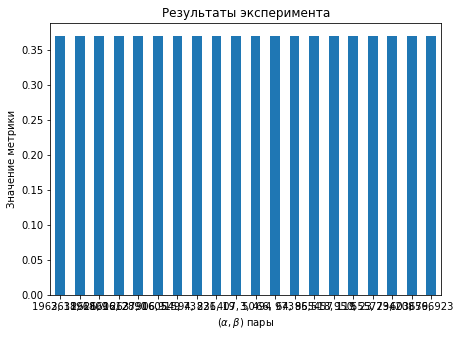

In [31]:
def plot_result_value(results):
    results['value_name'] = (results['params']['alpha'].astype(str)
                         .str.cat(results['params']['beta'].astype(str), sep=', '))
    
    plt.figure(figsize=(7, 5))
    ax = results['value'].plot(kind='bar', xticks=range(len(results)), rot=0)
    ax.set_xticklabels(results['value_name'].values)

    plt.xlabel(r'$(\alpha, \beta)$' + ' пары')
    plt.ylabel('Значение метрики')
    plt.title('Результаты эксперимента')

    plt.show()
    

plot_result_value(results)

In [32]:
%%time

best_recs = popular_scenario.production(
    best_params,
    df,
    users=None,
    items=None,
    user_features=None,
    item_features=None,
    k=10,
    context='no_context',
    to_filter_seen_items=True
)

11-Nov-19 13:22:01, root, DEBUG: Проверка датафреймов
11-Nov-19 13:22:01, root, DEBUG: Предварительная стадия обучения (pre-fit)
11-Nov-19 13:22:02, root, DEBUG: Среднее количество items у каждого user: 20.0
11-Nov-19 13:22:02, root, DEBUG: Основная стадия обучения (fit)
11-Nov-19 13:22:02, root, DEBUG: Проверка датафреймов
11-Nov-19 13:22:02, root, DEBUG: Выделение дефолтных юзеров
11-Nov-19 13:22:03, root, DEBUG: Выделение дефолтных айтемов
11-Nov-19 13:22:06, root, DEBUG: Количество items после фильтрации: 30


CPU times: user 52 ms, sys: 4 ms, total: 56 ms
Wall time: 5.68 s


In [33]:
best_recs.show(10)

+-------+-------+----------+--------------------+
|item_id|user_id|   context|           relevance|
+-------+-------+----------+--------------------+
|   2714| 100140|no_context|0.007287057585204545|
|    747| 100140|no_context|0.006556309298129127|
|   6127| 100140|no_context|0.005612391533439...|
|   3916| 100140|no_context|0.005205441047234...|
|   8771| 100140|no_context|0.005126331946349307|
|   3336| 100140|no_context|0.004936179795597...|
|   7079| 100140|no_context|0.004752248543998553|
|   3567| 100140|no_context|0.004586979989855787|
|   1016| 100140|no_context|0.004510359248631506|
|   9467| 100140|no_context|0.004061210329844...|
+-------+-------+----------+--------------------+
only showing top 10 rows



## Рекомендатель на основе k-NN для объектов (item k-NN based recommender) <a name='knn-recommender'></a>

### Запуск single модели <a name='knn-recommender-single'></a>

In [34]:
splitter = ValidationSchemes(spark)

train, test_input, test = splitter.log_split_randomly(
    df, test_size=0.2,
    drop_cold_users=False, drop_cold_items=True
)

(
    train.count(), 
    test_input.count(), 
    test.count()
)

(7716369, 7716369, 1926608)

In [35]:
knn = KNNRecommender(spark, num_neighbours=15, shrink=0)

In [36]:
%%time

knn.fit(
    log=train,
    user_features=None,
    item_features=None,
    path=None
)

11-Nov-19 13:25:03, root, DEBUG: Проверка датафреймов
11-Nov-19 13:25:06, root, DEBUG: Предварительная стадия обучения (pre-fit)
11-Nov-19 13:25:06, root, DEBUG: Основная стадия обучения (fit)


CPU times: user 20 ms, sys: 12 ms, total: 32 ms
Wall time: 3.45 s


In [37]:
%%time

recs = knn.predict(
    k=10,
    users=test.select('user_id').distinct(),
    items=test.select('item_id').distinct(),
    context='no_context',
    log=train,
    user_features=None,
    item_features=None,
    to_filter_seen_items=True,
    path=None
).cache()

11-Nov-19 13:25:11, root, DEBUG: Проверка датафреймов


CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 4.75 s


In [ ]:
recs.show(5)

In [38]:
%%time

metric = Metric.hit_rate_at_k(recs, test, k=10)
metric

CPU times: user 32 ms, sys: 16 ms, total: 48 ms
Wall time: 7min 14s


0.003990613764202536

### Подбор гиперпараметров в item k-NN модели <a name='knn-recommender-scenario'></a>

In [40]:
knn_scenario = KNNScenario(spark)
knn_scenario.seed = 7852
knn_results = None

In [43]:
%%time

knn_params_grid = {
    'num_neighbours': (1, 5, 1), 
    'shrink': [0]
}

best_params = knn_scenario.research(
    knn_params_grid,
    df,
    users=None, items=None,
    user_features=None,
    item_features=None,
    test_start=None,
    test_size=0.2,
    k=20, context='no_context',
    to_filter_seen_items=True,
    n_trials=4, 
    n_jobs=1,
    how_to_split='randomly'
)

11-Nov-19 15:23:37, root, DEBUG: Деление на трейн и тест
11-Nov-19 15:23:37, root, DEBUG: Длина трейна и теста: (7713379, 1927433)
11-Nov-19 15:23:39, root, DEBUG: Количество юзеров в трейне и тесте: 498842, 409781
11-Nov-19 15:23:39, root, DEBUG: Количество айтемов в трейне и тесте: 8261, 7892
11-Nov-19 15:23:39, root, DEBUG: Популярная модель: фит_предикт
11-Nov-19 15:23:39, root, DEBUG: Проверка датафреймов
11-Nov-19 15:23:39, root, DEBUG: Предварительная стадия обучения (pre-fit)
11-Nov-19 15:23:41, root, DEBUG: Среднее количество items у каждого user: 16.0
11-Nov-19 15:23:41, root, DEBUG: Основная стадия обучения (fit)
11-Nov-19 15:23:41, root, DEBUG: Проверка датафреймов
11-Nov-19 15:23:42, root, DEBUG: Количество items после фильтрации: 36
11-Nov-19 15:23:43, root, DEBUG: Модель KNN
11-Nov-19 15:23:43, root, DEBUG: Первый пре-фит модели
11-Nov-19 15:23:43, root, DEBUG: -------------
11-Nov-19 15:23:43, root, DEBUG: Начало оптимизации параметров
11-Nov-19 15:23:43, root, DEBUG: -

CPU times: user 1.09 s, sys: 208 ms, total: 1.3 s
Wall time: 5min 31s


In [44]:
knn_results = pd.concat([knn_scenario.study.trials_dataframe(), knn_results])

knn_results

number                state     value             datetime_start  \
                                                                     
0  0      TrialState.COMPLETE  0.139943 2019-11-11 15:23:43.604098   
1  1      TrialState.COMPLETE  0.056298 2019-11-11 15:25:12.527285   
2  2      TrialState.COMPLETE  0.056298 2019-11-11 15:26:31.740371   
3  3      TrialState.COMPLETE  0.041222 2019-11-11 15:27:42.444185   
0  0      TrialState.COMPLETE  0.003580 2019-11-11 13:56:35.289337   
1  1      TrialState.COMPLETE  0.011804 2019-11-11 14:07:37.678487   
2  2      TrialState.COMPLETE  0.004415 2019-11-11 14:09:31.897127   
3  3      TrialState.COMPLETE  0.016680 2019-11-11 14:13:12.466935   
4  4      TrialState.COMPLETE  0.006389 2019-11-11 14:14:59.747354   
5  5      TrialState.COMPLETE  0.008797 2019-11-11 14:17:36.122595   
6  6      TrialState.COMPLETE  0.002911 2019-11-11 14:19:41.264938   
7  7      TrialState.COMPLETE  0.004297 2019-11-11 14:25:33.517042   
8  8      TrialState.COMPLETE  0.003373 2019-11-11 14:29:14.172697   
9  9      TrialState.COMPLETE  0.026790 2019-11-11 14:33:52.846544   

           datetime_complete         params        user_attrs            \
                             num_neighbours shrink  HitRate@k     MAP@k   
0 2019-11-11 15:25:12.524270  1.0            0      0.139943   0.007845   
1 2019-11-11 15:26:31.737546  3.0            0      0.056298   0.002814   
2 2019-11-11 15:27:42.441122  3.0            0      0.056298   0.002814   
3 2019-11-11 15:29:09.441016  4.0            0      0.041222   0.001955   
0 2019-11-11 14:07:37.675145  69.0           0      0.003580   0.000123   
1 2019-11-11 14:09:31.893613  12.0           0      0.011804   0.000420   
2 2019-11-11 14:13:12.463589  48.0           0      0.004415   0.000146   
3 2019-11-11 14:14:59.744020  9.0            0      0.016680   0.000635   
4 2019-11-11 14:17:36.119107  24.0           0      0.006389   0.000207   
5 2019-11-11 14:19:41.261222  18.0           0      0.008797   0.000295   
6 2019-11-11 14:25:33.513099  99.0           0      0.002911   0.000094   
7 2019-11-11 14:29:14.168380  51.0           0      0.004297   0.000150   
8 2019-11-11 14:33:52.842318  75.0           0      0.003373   0.000113   
9 2019-11-11 14:35:33.600948  6.0            0      0.026790   0.001136   

                        system_attrs  
     nDCG@k precision@k      _number  
0  0.024849  0.007642    0            
1  0.009826  0.002983    1            
2  0.009826  0.002983    2            
3  0.006967  0.002177    3            
0  0.000396  0.000187    0            
1  0.001477  0.000628    1            
2  0.000482  0.000231    2            
3  0.002324  0.000885    3            
4  0.000710  0.000339    4            
5  0.001041  0.000463    5            
6  0.000313  0.000151    6            
7  0.000480  0.000225    7            
8  0.000368  0.000176    8            
9  0.004156  0.001413    9